In [1]:
import glob
import cv2
import numpy as np
import os
import shutil
import torchvision.transforms as T
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import random
import re
import torchvision.transforms as transforms

In [2]:
# シードを固定する関数
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# シードを固定
set_seed(42)

In [3]:
def make_models(model_paths):
        
    class DeepAutoencoder(nn.Module):
        def __init__(self):
            super(DeepAutoencoder, self).__init__()
            self.Encoder = nn.Sequential(
                nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 256 -> 128
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 128 -> 64
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 64 -> 32
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 32 -> 16
                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 16 -> 8
            )
            self.Decoder = nn.Sequential(
                nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # 8 -> 16
                nn.ReLU(),
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # 16 -> 32
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # 32 -> 64
                nn.ReLU(),
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # 64 -> 128
                nn.ReLU(),
                nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),  # 128 -> 256
                nn.ReLU(),
                nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            )

        def forward(self, x):
            x = self.Encoder(x)
            x = self.Decoder(x)
            return x
    
    models = []
    for model_path in model_paths:
        model = DeepAutoencoder().cuda()
        model.load_state_dict(torch.load(model_path))
        models.append(model)
    return models

In [4]:
# 画像分割サイズ
distance = 224

# 画像を分割する関数
def split(FILES):
    # 分割後の画像を分割前の画像ごとに格納
    split_images = []
    for i in range(len(FILES)):
        file = FILES[i]  # ファイル名
        img = Image.open(file)  # 画像読み込み
        img = np.array(img)  # Pillowの画像をnumpy配列に変換
        h, w = img.shape[:2]  # 画像のサイズ
        # 分割の始点
        cx = 0
        cy = 0
        for x in range(h // distance):
            for y in range(w // distance):
                # 画像の切り取り
                split_img = img[cx:cx + distance, cy:cy + distance]
                # 画像の格納
                split_images.append(Image.fromarray(split_img))  # numpy配列をPillowの画像に変換して格納
                cy += distance
            cy = 0
            cx += distance
    return split_images

In [5]:
d_model_paths = ["models/dmodels/100_fineAEdeepmodel_20250116_dlight.pth","models/dmodels/1000_fineAEdeepmodel_20250116_dlight.pth","models/dmodels/2000_fineAEdeepmodel_20250116_dlight.pth","models/dmodels/3000_fineAEdeepmodel_20250116_dlight.pth","models/dmodels/4000_fineAEdeepmodel_20250116_dlight.pth","models/dmodels/5000_fineAEdeepmodel_20250116_dlight.pth","models/dmodels/6048_fineAEdeepmodel_20250115_dlight.pth"]
r_model_paths = ["models/rmodels/100_fineAEdeepmodel_20250116_rlight.pth","models/rmodels/1000_fineAEdeepmodel_20250116_rlight.pth","models/rmodels/2000_fineAEdeepmodel_20250116_rlight.pth","models/rmodels/3000_fineAEdeepmodel_20250116_rlight.pth","models/rmodels/4000_fineAEdeepmodel_20250116_rlight.pth","models/rmodels/5000_fineAEdeepmodel_20250116_rlight.pth","models/rmodels/6048_fineAEdeepmodel_20250115_rlight.pth"]
# 数字の大きさでソート
d_model_paths = sorted(d_model_paths, key=lambda x: int(x.split('/')[2].split('_')[0]))
r_model_paths = sorted(r_model_paths, key=lambda x: int(x.split('/')[2].split('_')[0]))

files = list(glob.glob("imgs/test_objects/detected_1_65.jpg"))
split_images = split(files)


/tmp/ipykernel_1913227/309347958.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


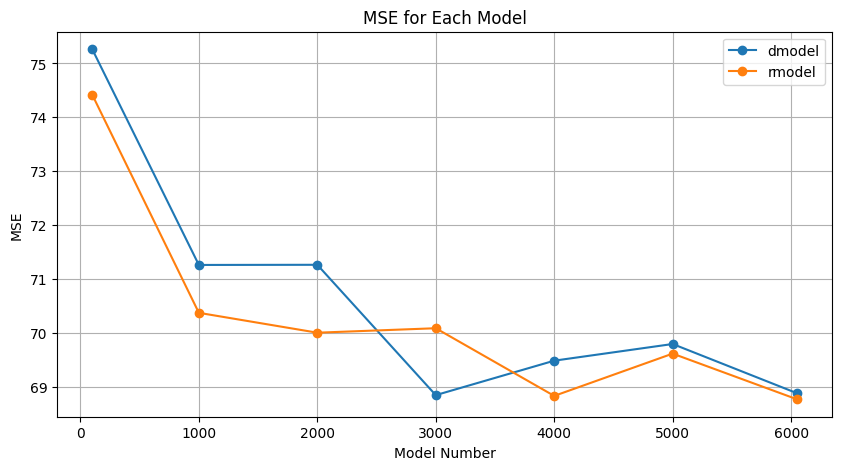

In [6]:
# モデルを作成
d_models = make_models(d_model_paths)
r_models = make_models(r_model_paths)

# MSEを計算する関数
def calculate_mse(img1, img2):
    return np.mean((img1 - img2) ** 2)

# 前処理を定義
preprocess = transforms.Compose([
    transforms.ToTensor()
])

# MSEを計算してプロット
def plot_mse(models, model_paths, split_images, label):
    mse_values = []
    model_numbers = [int(path.split('/')[2].split('_')[0]) for path in model_paths]

    for model in models:
        model.eval()
        mse_sum = 0
        for img in split_images:
            img_tensor = preprocess(img).unsqueeze(0).cuda()
            with torch.no_grad():
                output = model(img_tensor)[0]
            output = output.cpu().numpy().transpose(1, 2, 0)
            output = np.uint8(np.maximum(np.minimum(output * 255, 255), 0))
            origin = np.uint8(img_tensor[0].cpu().numpy().transpose(1, 2, 0) * 255)
            mse_sum += calculate_mse(origin, output)
        mse_values.append(mse_sum / len(split_images))

    return model_numbers, mse_values

# プロット
d_model_numbers, d_mse_values = plot_mse(d_models, d_model_paths, split_images, 'dmodel')
r_model_numbers, r_mse_values = plot_mse(r_models, r_model_paths, split_images, 'rmodel')

plt.figure(figsize=(10, 5))
plt.plot(d_model_numbers, d_mse_values, marker='o', label='dmodel')
plt.plot(r_model_numbers, r_mse_values, marker='o', label='rmodel')
plt.xlabel('Model Number')
plt.ylabel('MSE')
plt.title('MSE for Each Model')
plt.legend()
plt.grid(True)
plt.show()